#### demo3: Using the K-means algorithm to cluster profiles

In [7]:
import gsw
import numpy as np
import pandas as pd
from netCDF4 import Dataset
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from matplotlib import cm, pyplot as plt

###############################################################
# Get interpolated data from Argo profiles
###############################################################
def getProfileData(file):
	# parameters:
	# 	file: String: full path of the profile file
 
	nc = Dataset(file)
	latitude = nc.variables['LATITUDE'][0]
	longitude = nc.variables['LONGITUDE'][0]
	df = pd.DataFrame({
		'pres': nc.variables['PRES_ADJUSTED'][0], 
		'psal': nc.variables['PSAL_ADJUSTED'][0], 
		'temp': nc.variables['TEMP_ADJUSTED'][0]
	})
	df = df.dropna()
	nc.close()
	
	less = df[df.pres <= 10].pres
	more = df[df.pres >= 1500].pres
	if (less.shape[0] == 0) | (more.shape[0] == 0):
		return pd.DataFrame([])
	
	# Here you can add the missing filters described in the manuscript or filters proposed by you.
 	# Remember to return an empty Pandas dataframe if the profile does not pass any filter.

	df = df[(df.pres >= less.values[-1]) & (df.pres <= more.values[0])].reset_index(drop=True)

	df['asal'] = gsw.SA_from_SP(df.psal.values, df.pres.values, np.repeat(longitude, df.shape[0]), np.repeat(latitude, df.shape[0]))
	df['ctemp'] = gsw.CT_from_t(df.asal.values, df.temp.values, df.pres.values)

	pres = np.arange(10, 1501, 1)
	t = interp1d(df.pres, df.ctemp)
	s = interp1d(df.pres, df.asal)
	interp_df = pd.DataFrame({
		'pres': pres, 
		'asal': s(pres), 
		'ctemp': t(pres)
	})
	return interp_df

Below is the simplified procedure to obtain k centroids from temperature profiles. These can be modified using salinity profiles or any other parameter.

First, profiles with measurements from 10 to 1500 m are selected and linearly interpolated at each meter of depth, as mentioned in the manuscript. For this demonstration, five random DMQC profiles were selected from the Argo snapshot used in the manuscript (see file `README.md`). To simplify the demo procedures, on this occasion we do not perform exhaustive filtering with these five profiles.

In [8]:
profile_files = ["D5904999_148.nc", "D3901116_098.nc", "D5904355_088.nc", "D2902612_192.nc", "D3900386_063.nc"]

files = []
pres = np.arange(10, 1501, 1).tolist()
ct_profiles = pd.DataFrame({}, columns=pres)

for file in profile_files:
    df = getProfileData(f"argo-profiles/{file}")
    # Adding datasets that did pass the filters
    if df.shape[0] > 0:
        files.append(file)
        ct_profiles.loc[len(ct_profiles.index)] = df.ctemp.values

ct_profiles["file"] = files
print(f"{ct_profiles.shape[0]} interpolated conservative temperature profiles")

4 interpolated conservative temperature profiles


Once the training instances for clustering (profiles) have been obtained, we use K-Means clustering, in this case with 10,000 as the maximum number of iterations and 10 as the number of times the K-means algorithm is executed with different seeds of centroid.

In [9]:
k = 2 # Could be np.arange(2,51) using a loop

kmeanModel = KMeans(n_clusters=k, max_iter=10000, n_init=10, verbose=0)
kmeanModel.fit(ct_profiles.values[:,:-1])

centroids = pd.DataFrame(kmeanModel.cluster_centers_.T)
centroids

c:\Users\USER\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,0,1
0,29.393294,10.838796
1,29.387139,10.837945
2,29.380972,10.837571
3,29.374577,10.837261
4,29.368182,10.837144
...,...,...
1486,3.560542,2.681336
1487,3.555527,2.680447
1488,3.550461,2.680112
1489,3.545185,2.679551


The table above shows the coordinates of cluster centers. Each cluster is located in a column, as _k_=2, clousters 0 and 1 (0 to _k_-1) were obtained. Rows are the values of the centroids from 10 m to 1500 m at each meter of depth.

Now we can assign the corresponding cluster to each of the profiles that we used for training or assign new profiles through the centroids and the use of the Euclidean distance (see `demo2.ipynb`).

In [10]:
column = f"{k}_t"
ct_profiles[column] = kmeanModel.labels_
ct_profiles[["file",column]]

,file,2_t
0,D5904999_148.nc,1
1,D3901116_098.nc,1
2,D5904355_088.nc,0
3,D2902612_192.nc,0


Now you can see your classified profiles on a map (see `demo1.ipynb`) or plot them on a p-T diagram per cluster.

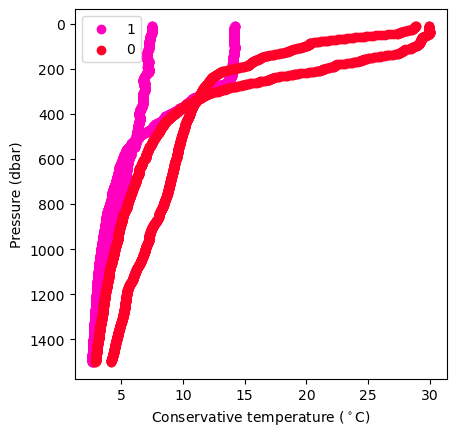

In [11]:
fig = plt.figure(figsize=(4.8, 4.8))
ax = fig.add_subplot(111)

uniques = ct_profiles[column].unique()
cmap = cm.get_cmap('gist_rainbow_r', len(uniques))

for k in range(len(uniques)):
    _ct_profiles = ct_profiles[ct_profiles[column] == uniques[k]]
    for p in range(_ct_profiles.shape[0]):
        label = _ct_profiles[column].values[0] if p == 0 else None
        ax.scatter(_ct_profiles[pres].values[p], pres, color=cmap(k), label=label)

ax.invert_yaxis()
ax.set_xlabel(r"Conservative temperature ($^\circ$C)")
ax.set_ylabel(r"Pressure (dbar)")
ax.legend()